In [1]:
import os
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib_venn import venn3
import numpy as np
from itertools import combinations
from scipy.stats import pearsonr

# Variables

In [3]:
# folder where the csv files for measurements are saved
export_path = '../data/exports/'
analysis_path = '../data/analysis/'

# dictionary of stainings (in the same order as they appear in the export table, usually channels order)
# they must be the same names used for classification
markers = {
    'Channel 2': 'IB4',
    'Channel 3': 'TREK1',
    'Channel 4': 'NeuN'
    }

# colors for graphs (see available colors here: https://matplotlib.org/stable/gallery/color/named_colors.html)
colors = {
    'IB4': 'limegreen',
    'TREK1': 'red',
    'NeuN': 'mediumorchid'
    }

# position of DRG level in the filename (S, L, T, C) - start from zero (eg: in 'DRG Lumbar Female 2 coupe 4', L is at position 4)
# note: you can execute cells all the way to the first cell in 'Extract features from image file names' to have the first filename printed and see how it looks
level_pos = 4
# position of sex in the filename (F, M) (eg: in 'DRG Lumbar Female 2 coupe 4', F is at position 11)
sex_pos = 6
# position of animal number in the filename (eg: in 'DRG Lumbar Female 2 coupe 4', 2 is at position 18)
animal_pos = 7
# position of slice number in the filename  (eg: in 'DRG Lumbar Female 2 coupe 4', 2 is at position -1, starting from the end)
slice_pos = -1

# Clean the analysis folder

In [4]:
for filename in os.listdir(analysis_path):
    file_path = os.path.join(analysis_path, filename)
    # Skip directories and .gitkeep
    if filename != ".gitkeep":
        os.remove(file_path)
print(f'\nAll files in the folder {analysis_path} have been deleted.\n')


All files in the folder ../data/analysis/ have been deleted.



# Extract and cleanup data

## read all csv files in a single dataframe

In [5]:
df = pd.DataFrame()
for file in os.listdir(export_path):
    if file.endswith('csv'):
        file_path = os.path.join(export_path, file)
        temp_df = pd.read_csv(file_path, sep="\t")
        df = pd.concat ([df, temp_df], ignore_index=True)
pd.concat([df.head(1), df.tail(1)]) # show first and last row of the dataframe

,Image,Object ID,Object type,Name,Classification,Parent,ROI,Centroid X µm,Centroid Y µm,ROI: 2.00 µm per pixel: Channel 2: Mean,ROI: 2.00 µm per pixel: Channel 3: Mean,ROI: 2.00 µm per pixel: Channel 4: Mean,Area µm^2,Circularity,Max diameter µm
0,DRG C F1_NeuN_IB4_Td-tomato_DAPI.lif - DRG C F...,0ce018eb-be17-4784-b478-27dfbb1c52fe,Detection,NaN,NeuN: Ignore*,Root object (Image),Polygon,372.50,625.78,3101.9043,611.3475,4035.1240,1158.4976,0.6096,45.9216
1694,DRG T M1_NeuN_IB4_Td-tomato_DAPI.lif - DRG T M...,7629ded0-776f-4042-ab8a-fb4107ea9c92,Detection,NaN,Ignore*,Root object (Image),Polygon,251.88,584.65,1023.1539,318.3077,453.3846,61.9975,0.5508,12.9836


## Remove unwanted columns

In [6]:
df = df.drop(columns=[
    'Object ID',
    'Object type',
    'Name',
    'Parent',
    'ROI',
    'Centroid X µm',
    'Centroid Y µm',
])
pd.concat([df.head(1), df.tail(1)]) # show first and last row of the dataframe

,Image,Classification,ROI: 2.00 µm per pixel: Channel 2: Mean,ROI: 2.00 µm per pixel: Channel 3: Mean,ROI: 2.00 µm per pixel: Channel 4: Mean,Area µm^2,Circularity,Max diameter µm
0,DRG C F1_NeuN_IB4_Td-tomato_DAPI.lif - DRG C F...,NeuN: Ignore*,3101.9043,611.3475,4035.1240,1158.4976,0.6096,45.9216
1694,DRG T M1_NeuN_IB4_Td-tomato_DAPI.lif - DRG T M...,Ignore*,1023.1539,318.3077,453.3846,61.9975,0.5508,12.9836


## Rename columns

In [7]:
# create a dictionary of {old_names: new_names} to rename columns
# first create names for mean fluorescence intensities for each marker based on the given markers dictionary
rename_map = {
    f'ROI: 2.00 µm per pixel: {old_name}: Mean': f'{new_name}_mean'
    for old_name, new_name in markers.items()
}

# map other columns names
rename_map.update({
    'Area µm^2': 'area',
    'Circularity': 'circularity',
    'Max diameter µm': 'max_diameter'
})

# apply renaiming to columns
df = df.rename(columns=rename_map)

pd.concat([df.head(1), df.tail(1)]) # show first and last row of the dataframe

,Image,Classification,IB4_mean,TREK1_mean,NeuN_mean,area,circularity,max_diameter
0,DRG C F1_NeuN_IB4_Td-tomato_DAPI.lif - DRG C F...,NeuN: Ignore*,3101.9043,611.3475,4035.1240,1158.4976,0.6096,45.9216
1694,DRG T M1_NeuN_IB4_Td-tomato_DAPI.lif - DRG T M...,Ignore*,1023.1539,318.3077,453.3846,61.9975,0.5508,12.9836


## Extract features from image file names

In [8]:
# look at the first image name
df.Image[0]

'DRG C F1_NeuN_IB4_Td-tomato_DAPI.lif - DRG C F1_coupe 4'

In [9]:
# get the DRG level
df['level'] = df.Image.str[level_pos]

# get the sex
df['sex'] = df.Image.str[sex_pos]

# create a unique animal ID including sex and animal number (eg 'F2' for female 2)
df['animal'] = (df['sex'] + df['Image'].str[animal_pos])

# create a unique sample ID including level, sex, and animal number (eg 'LF2' for lumbar female 2)
df['sample'] = (df['level'] + df['sex'] + df['Image'].str[animal_pos])

# create a unique slice ID by adding the slice number to the sample ID (eg 'LF2.4' for lumbar female 2, slice 4)
df['slice'] = (df['sample'] + '.' + df.Image.str[slice_pos])

# get the cell number using cumulative count on data grouped by animal and slice
df['cell'] = df.groupby(['animal', 'slice']).cumcount() + 1

# remove the Image column and move our new columns first
df = df.drop(columns=['Image'])
new_cols =  ['level', 'sex', 'animal', 'sample', 'slice', 'cell']
ordered_cols = new_cols + [c for c in df.columns if c not in new_cols]
df = df[ordered_cols]

In [10]:
# rename levels
mapping = {
    'L': 'Lumbar',
    'T': 'Thoracic',
    'C': 'Cervical'
}
df['level'] = df['level'].replace(mapping)

# rename levels
mapping = {
    'F': 'Female',
    'M': 'Male'
}
df['sex'] = df['sex'].replace(mapping)

pd.concat([df.head(1), df.tail(1)]) # show first and last row of the dataframe

,level,sex,animal,sample,slice,cell,Classification,IB4_mean,TREK1_mean,NeuN_mean,area,circularity,max_diameter
0,Cervical,Female,F1,CF1,CF1.4,1,NeuN: Ignore*,3101.9043,611.3475,4035.1240,1158.4976,0.6096,45.9216
1694,Thoracic,Male,M1,TM1,TM1.1,161,Ignore*,1023.1539,318.3077,453.3846,61.9975,0.5508,12.9836


## Extract classification

In [13]:
# create new columns with booleans for each classification, based on the Classification column
for m in markers.values():
    df[m + '_class'] = df['Classification'].str.contains(m)
# delete column Classification
df = df.drop(columns=['Classification'])

pd.concat([df.head(1), df.tail(1)]) # show first and last row of the dataframe

KeyError: 'Classification'

## Save dataframe to Excel

In [14]:
df.to_excel(analysis_path + 'cleaned_data.xlsx')

# Global plots

## Intensity distribution

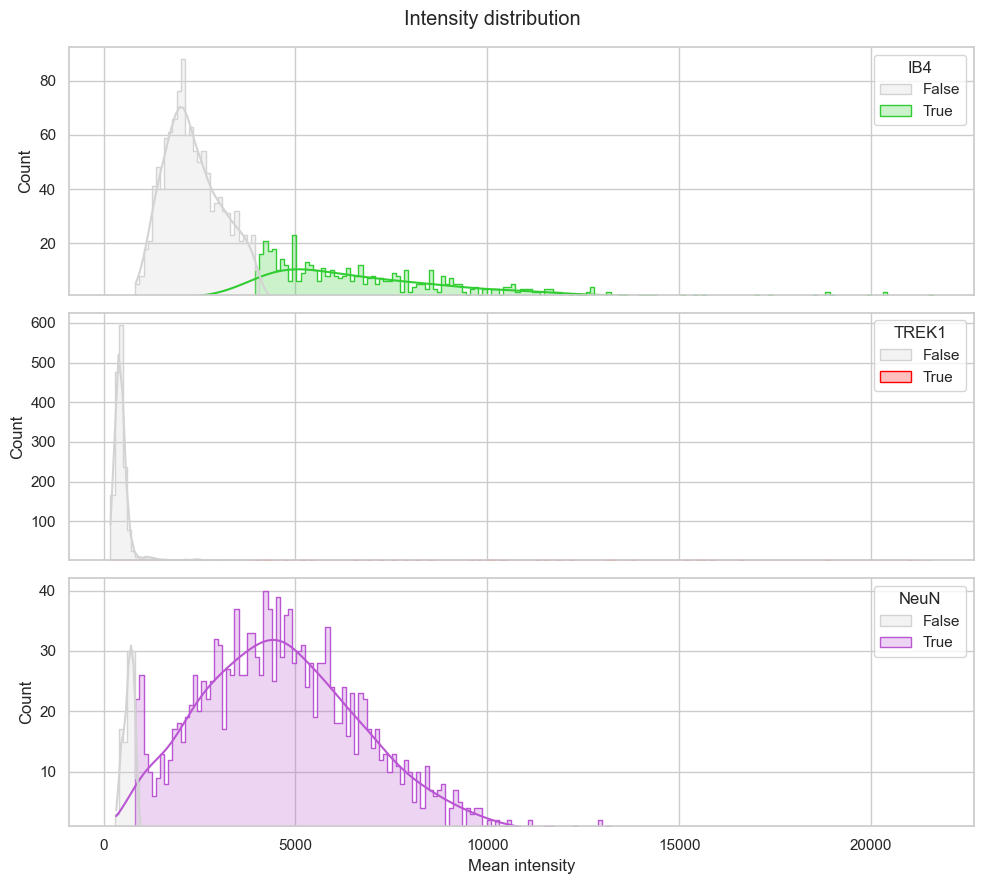

In [15]:
# set number of bins for histograms
bins = 200

# extract only columns with mean intensities
mean_cols = [col for col in df.columns if 'mean' in col.lower()]

# set seaborn style
sns.set(style="whitegrid")

# find common x limits for the shared x axis and compute bins
xmin = min(df[col].min() for col in mean_cols)
xmax = max(df[col].max() for col in mean_cols)
bins = np.linspace(xmin, xmax, bins)

# create stacked subplots
fig, axes = plt.subplots(len(mean_cols), 1, figsize=(10, 3 * len(mean_cols)), sharex=True)

# create figure
for ax, col in zip(axes, mean_cols):
    marker = col.replace('_mean', '') # get marker name
    color = colors[marker] # get marker color
    sns.histplot(
        data=df,
        x=col,
        hue=f'{marker}_class', # separate True/False for the current marker
        kde=True, # add kernel density estimate (probability density curve)
        bins=bins,
        element='step', # how bars are drawn, allows clear overlap between distributions
        palette={True: color, False: 'lightgray'}, # use color for 'True' cells, grey for 'False' cells
        ax=ax, # tell seaborn to draw on the current subplot
    )
    ax.set_xlabel('')
    ax.set_ylabel('Count')
    ax.set_ylim(bottom=1)
    ax.legend_.set_title(marker)

# Label only the bottom x-axis
axes[-1].set_xlabel('Mean intensity')

plt.suptitle('Intensity distribution')
plt.tight_layout()

plt.savefig(analysis_path + "intensity_distribution.png", dpi=300, bbox_inches='tight')
plt.show()

## Correlations between markers intensities

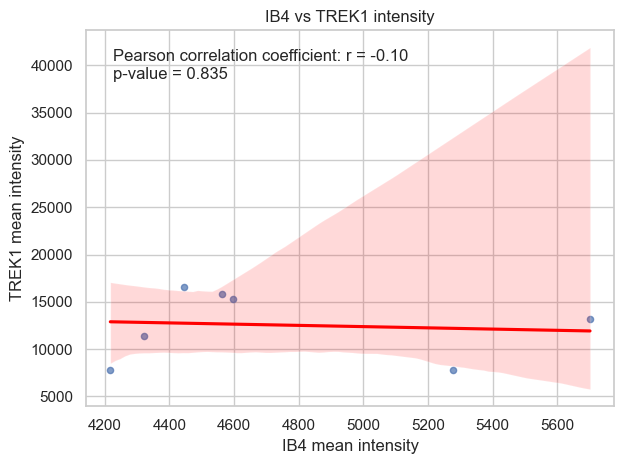

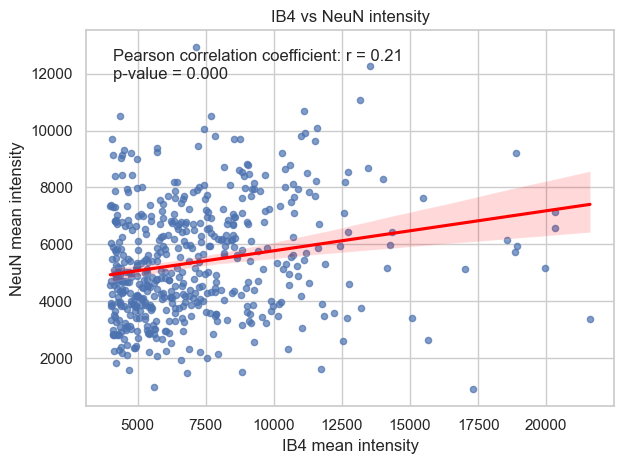

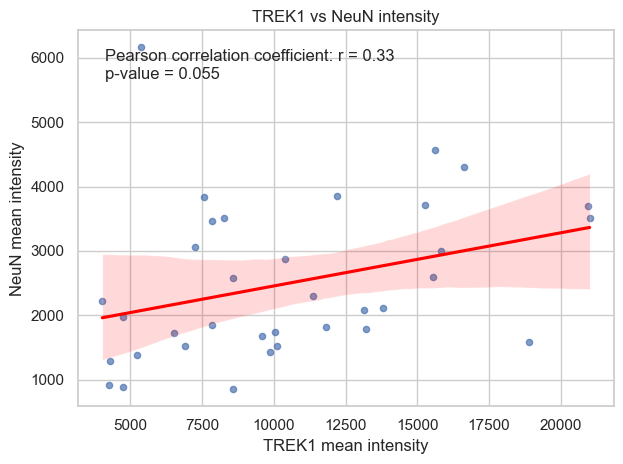

In [16]:
# extract columns with mean intensities and columns with classes
mean_cols = [f"{m}_mean" for m in markers.values()]
class_cols = [f"{m}_class" for m in markers.values()]

# set seaborn style
sns.set(style="whitegrid")

# loop over all marker pairs
for m1, m2 in combinations(markers.values(), 2):
    # get intensity and class columns for each marker of the pair
    mean1 = f"{m1}_mean"
    mean2 = f"{m2}_mean"
    class1 = f"{m1}_class"
    class2 = f"{m2}_class"
    
    # filter cells positive for both markers
    df_pair = df[(df[class1]) & (df[class2])]
    
    # compute correlation coefficient
    if len(df_pair) > 1:
        r, p = pearsonr(df_pair[mean1], df_pair[mean2])
    else:
        r, p = (np.nan, np.nan)  # not enough points

    # scatterplot with linear regression an 95% confidence interval
    sns.regplot(
    data=df_pair,
    x=mean1,
    y=mean2,
    scatter=True, # show individual points
    line_kws={'color':'red'},  # line color
    scatter_kws={'s': 20, 'alpha':0.7, }  # points size and transparency
)
    
    # add correlation test results
    plt.text(
        0.05, 0.95,
        f"Pearson correlation coefficient: r = {r:.2f}\np-value = {p:.3f}",
        transform=plt.gca().transAxes,
        verticalalignment='top'
    )
    
    plt.xlabel(f"{m1} mean intensity")
    plt.ylabel(f"{m2} mean intensity")
    plt.title(f"{m1} vs {m2} intensity")
    plt.tight_layout()
    plt.savefig(analysis_path + f"intensity_correlation_{m1}_{m2}.png", dpi=300, bbox_inches='tight')
    plt.show()

# Global/filtered plots

## Venn diagrams

In [17]:
"""
Function to plot the coexpression of maximum 3 markers in a Venn diagram
"""
def plot_venn(df, filter_list=[], numbers='count'):
    """
    filter_list : list of dicts
        Each dict contains filters for which a Venn diagram will be plotted.
        Use an empty dictionary to plot unfiltered data.
        Example: [ {}, {'sex':'M','level':'T'}, {'slice':'LF2.4'} ] to plot 1) all data, 2) males/thoracic only and 3) only lumbar female 2 slice 4
    numbers : int
        'count' or 'percentage'
    """
    
    # list class columns in the dataframe and corresponding markers names
    class_cols = [col for col in df.columns if col.endswith('_class')]
    marker_names = [col.replace('_class','') for col in class_cols] 

    # get the number of filters (= number of plots)
    n = len(filter_list)

    # if no filter is given, still make one graph with all data
    if n == 0:
        filter_list = [{}]
        n = 1

    # create figure with one row and n columns
    fig, axes = plt.subplots(1, n, figsize=(4*n, 4))

    # if only one filter is given, make it iterable for the upcoming loop works
    if n == 1: axes = [axes]  

    # loop through subplots/filters combinations
    for ax, filters in zip(axes, filter_list):
        # start with an unfiltered copy of the dataframe
        df_filtered = df.copy() 
        
        # apply filters one by one
        if filters:
            for col, val in filters.items():
                df_filtered = df_filtered[df_filtered[col] == val]
            # create a string to display filters in the graph title
            filter_str = ", ".join([f"{k}={v}" for k, v in filters.items()])
        else:
            filter_str = r"all\ cells" # raw string literal is needed as this string is written in the title with LaTeX
        
        # compute sets of filtered indices that will be used by the venn2 and venn3 functions
        sets = [set(df_filtered.index[df_filtered[c]]) for c in class_cols]
        total = len(df_filtered) # total number of cells to calculate percentages
        
        # plot Venn (2 or 3 classes only)
        if len(sets) == 2:
            v = venn2(sets, set_labels=marker_names, ax=ax)
        elif len(sets) == 3:
            v = venn3(sets, set_labels=marker_names, ax=ax)
        else:
            raise ValueError("Only 2 or 3 markers supported.")

        # set labels sizes
        for label in v.set_labels: # outer labels (markers)
            if label:
                label.set_fontsize(14)  
        for label in v.subset_labels: # intersection numbers (counts/percentages)
            if label:
                label.set_fontsize(12)  
        
        # replace labels if showing percentages
        if numbers == 'percentage':
            for label_id in v.subset_labels:
                if label_id is not None:
                    try:
                        count = int(label_id.get_text())
                        pct = (count / total) * 100
                        label_id.set_text(f"{pct:.1f}")
                    except (TypeError, ValueError):
                        # sometimes subset label may be None or empty
                        pass
        
        ax.set_title(rf"Markers co-expression for $\bf{{{filter_str}}}$", fontsize=12)
    
    plt.tight_layout()
    # write filters in the figure filename
    if filter_list:
        filter_str = "_".join(
            str(v) for d in filter_list for v in d.values()
            )
    else:
        filter_str = "unfiltered"
    plt.savefig(analysis_path + f"venn_{numbers}_{filter_str}.png", dpi=300, bbox_inches='tight')
    plt.show()

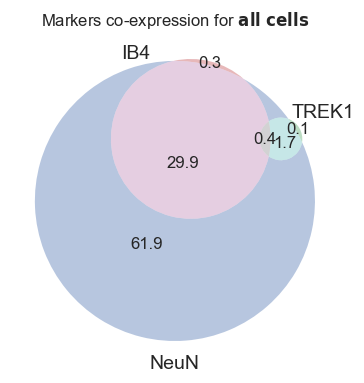

In [20]:
# Plot Venn diagram for all cells
plot_venn(df, numbers='percentage')

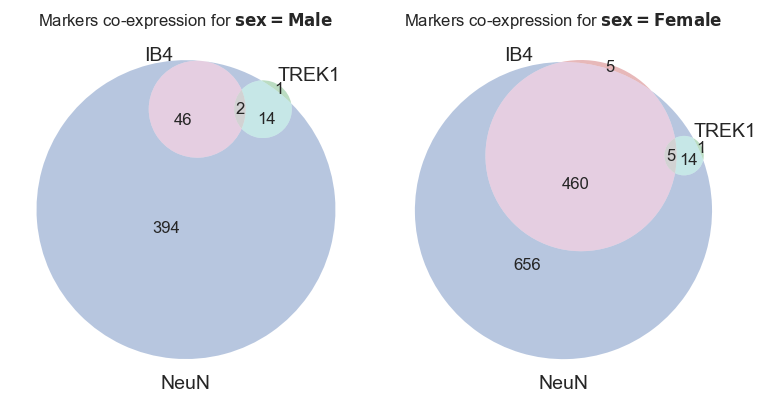

In [21]:
# Plot Venn diagram for both sexes
plot_venn(df, filter_list=[{'sex': 'Male'}, {'sex': 'Female'}], numbers='count')

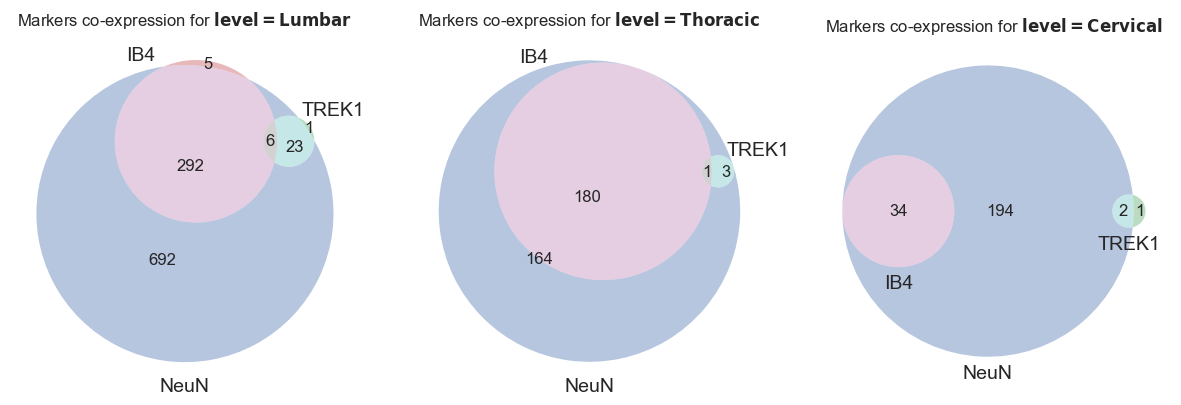

In [22]:
# Plot Venn diagram for the three levels
plot_venn(df, filter_list=[{'level': 'Lumbar'}, {'level': 'Thoracic'}, {'level': 'Cervical'}], numbers='count')

## Percentages of coexpression

In [23]:
"""
Function to plot the % of positive cells for a marker (numerator) within the cells positive for another marker (denominator)
eg. IB4+ cells within NeuN+ cells
"""
def plot_percentage(
    df, 
    marker_num, # numerator marker
    marker_den, # denominator marker
    group_by=None, # column of the dataframe to group vertical plots, on which average % will be calculated (eg. level, animal)
    individual='slice', # column of the dataframe on which individual % (datapoints) will be calculated (eg. sample, slide)
    hue=None, # column of the dataframe on which coloring will be based (eg. sex)
    ylim=100 # modify the upper limit of the y axis
    ):

    # add '_class' to markers to match column names
    marker_num = marker_num + '_class'
    marker_den = marker_den + '_class'

    # filter to denominator-positive cells
    df_den = df[df[marker_den]]

    # if no grouping, create a dummy column
    if group_by is None:
        df_den = df_den.copy()
        df_den['all'] = ''
        group_by = 'all'    

    # compute % marker_num+ within marker_den+ per individual in a summary df
    summary = (
        df_den.groupby(individual)[marker_num] # group cells by 'individual' level (datapoints)
        .mean()                                # calculate the ratio of positive cells (average of 1 (true) and 0 (false))
        .reset_index(name='percentage')        # makes it a dataframe and rename the column
    )
    summary['percentage'] *= 100 # convert ratios to %
    
    # add relevant data for grouping and hue to the summary df
    summary[group_by] = df_den.groupby(individual)[group_by].first().values
    if hue:
        summary[hue] = df_den.groupby(individual)[hue].first().values

    # Calculate aspect ratio based on the number of groups
    n_groups = summary[group_by].nunique()
    width_per_group = 2.0  # inches per group
    fig_width = max(1.5, min(width_per_group * n_groups, 20))  # constrain between 4 and 20 inches
    fig_height = 6
    aspect = fig_width / fig_height
    
    # set seaborn style
    sns.set(style="whitegrid", context="talk")

    # plot
    g = sns.catplot(
        data=summary,
        x=group_by,
        y="percentage",
        hue=hue,
        kind="strip",
        dodge=True if hue else False,
        jitter=True,
        height=6,
        aspect=aspect,
        s=50,
        alpha=0.8,
        legend_out=True
    )

    ax = g.axes[0, 0] # to access the correct axes object in the FacetGrid

    # overlay global mean ± SD per group
    stats = summary.groupby(group_by)['percentage'].agg(['mean','std']).reset_index()
    for i, row in stats.iterrows():
        # horizontal line = mean
        ax.hlines(y=row['mean'], xmin=i-0.3, xmax=i+0.3, color='black', linewidth=1.5, zorder=3)
        # vertical line = SD
        ax.vlines(x=i, ymin=row['mean']-row['std'], ymax=row['mean']+row['std'], color='black', linewidth=0.5, zorder=3)

    ax.set_xlabel(group_by)
    ax.set_ylabel(f"% {marker_num.replace('_class','')}+ within {marker_den.replace('_class','')}+")
    g.figure.suptitle(
        f"{marker_num.replace('_class','')}+ within {marker_den.replace('_class','')}+\n"
        f"(grouped by {group_by}, datapoint = {individual})"
        )
    ax.set_ylim(0, ylim)
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    plt.savefig(analysis_path + f"PC_coexpression_{marker_num}_{marker_den}_BY_{group_by}_INDIV_{individual}_HUE_{hue}.png", dpi=300, bbox_inches='tight')
    plt.show()

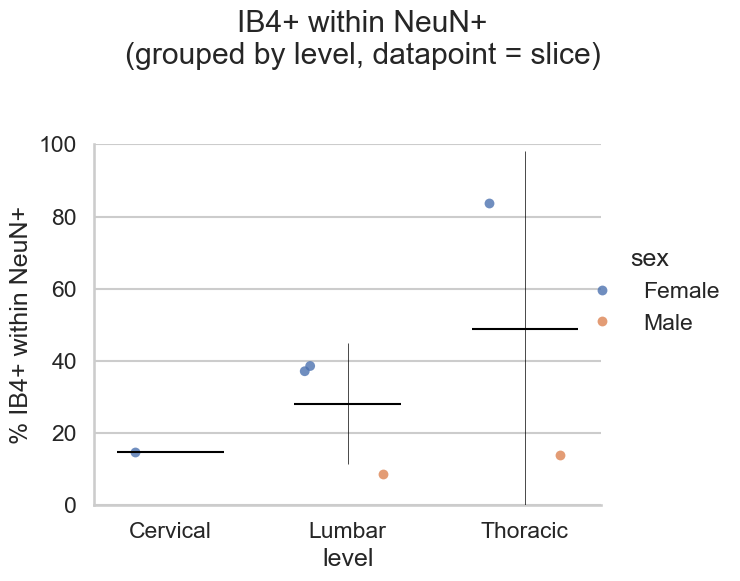

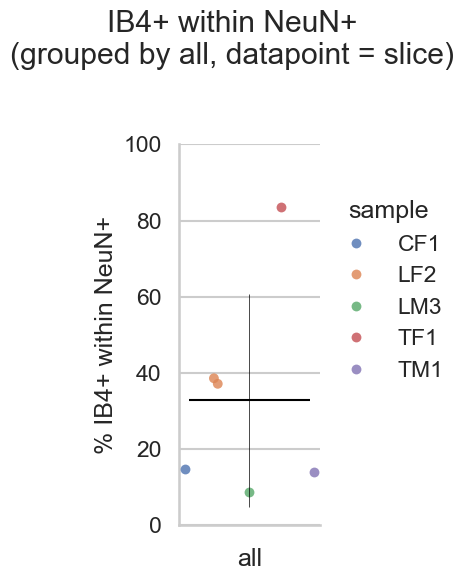

In [24]:
# Percentage of TREK1+ within NeuN+, grouped by animal, individual points per slice, hue = sex
plot_percentage(df, 'IB4', 'NeuN', group_by='level', individual='slice', hue='sex')

# Percentage of IB4+ within TREK1+, grouped by level, points per animal, hue = sex
plot_percentage(df, 'IB4', 'NeuN', group_by=None, individual='slice', hue='sample')

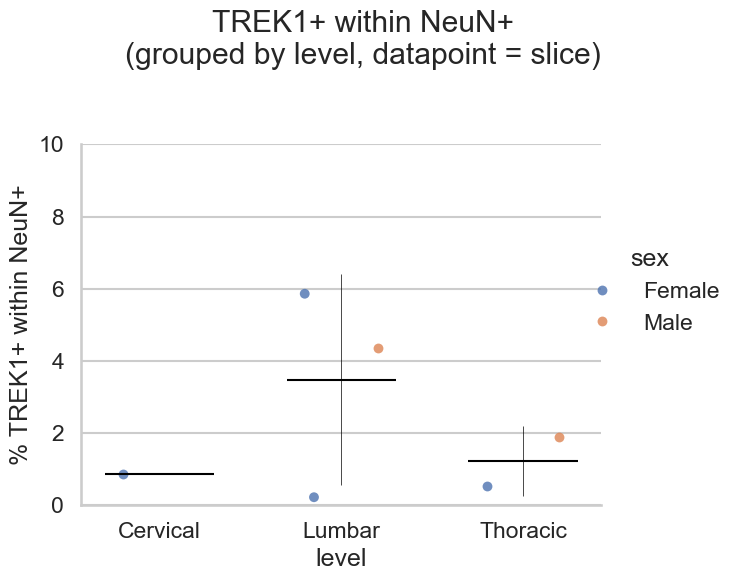

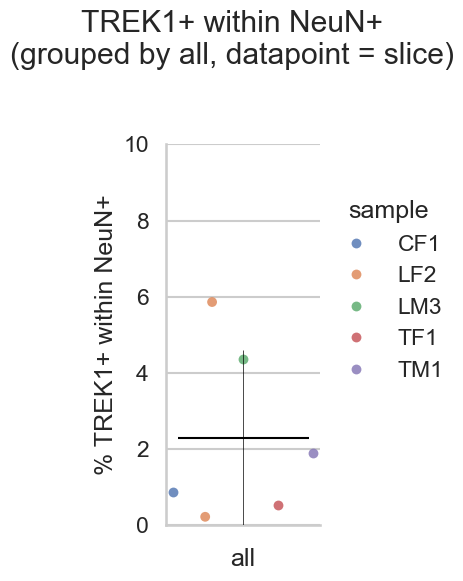

In [25]:
# Percentage of TREK1+ within NeuN+, grouped by animal, individual points per slice, hue = sex
plot_percentage(df, 'TREK1', 'NeuN', group_by='level', individual='slice', hue='sex', ylim=10)

# Percentage of IB4+ within TREK1+, grouped by level, points per animal, hue = sex
plot_percentage(df, 'TREK1', 'NeuN', group_by=None, individual='slice', hue='sample', ylim=10)

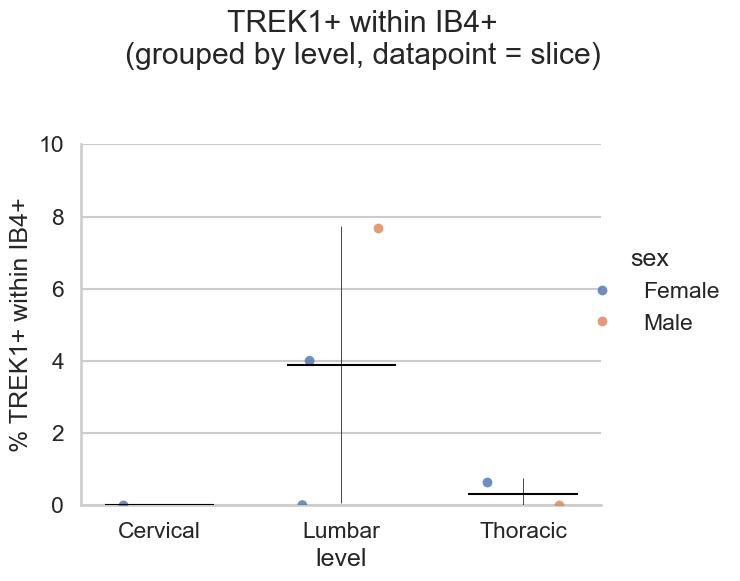

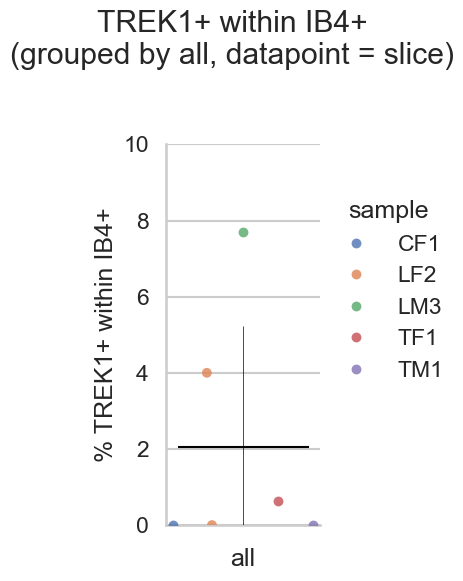

In [26]:
# Percentage of TREK1+ within NeuN+, grouped by animal, individual points per slice, hue = sex
plot_percentage(df, 'TREK1', 'IB4', group_by='level', individual='slice', hue='sex', ylim=10)

# Percentage of IB4+ within TREK1+, grouped by level, points per animal, hue = sex
plot_percentage(df, 'TREK1', 'IB4', group_by=None, individual='slice', hue='sample', ylim=10)

In [27]:
"""
Function to overlap two histograms (with Kernel Density Estimate curves) of cells area or diameter
"""
def plot_histogram(
    df,
    active_marker, # histogram will appear in color (from the colors dictionary, or default if marker is not found)
    background_marker, # histogram will appear in light gray
    metric='area', # 'area' or 'max_diameter'
    bins=30 # number of bins for both histograms
    ):

    # add '_class' to markers to match column names
    active_marker_col = active_marker + '_class'
    background_marker_col = background_marker + '_class'
    
    # filter the dataframe for positive cells
    df_active = df[df[active_marker_col]]
    df_background = df[df[background_marker_col]]

    # compute common bin edges
    all_areas = pd.concat([df_active[metric], df_background[metric]])
    bin_edges = np.linspace(all_areas.min(), all_areas.max(), bins + 1)

    # set active histogram color (if marker is found in the color dict, else set to default)
    active_color = colors.get(active_marker, 'orangered')

    # create the plot
    plt.figure(figsize=(8, 5))
    
    # plot background histogram + KDE
    sns.histplot(
        df_background[metric], bins=bin_edges, color='gray', label=background_marker,
        alpha=0.4, kde=True, stat='probability'
    )
    
    # plot active marker histogram + KDE
    sns.histplot(
        df_active[metric], bins=bin_edges, color=active_color, label=active_marker,
        alpha=0.5, kde=True, stat='probability'
    )

    # customize appearance
    if metric == 'area':
        plt.xlabel('Cell area (µm²)')
        plt.title(f'Cell area distribution for {active_marker} and {background_marker}')
    elif metric == 'max_diameter':
        plt.xlabel('Max cell diameter (µm)')
        plt.title(f'Max cell diameter distribution for {active_marker} and {background_marker}')
    plt.ylabel('Probability')
    plt.legend()
    plt.tight_layout()
    plt.savefig(analysis_path + f"histogram_{metric}_{active_marker}_{background_marker}.png", dpi=300, bbox_inches='tight')
    plt.show()

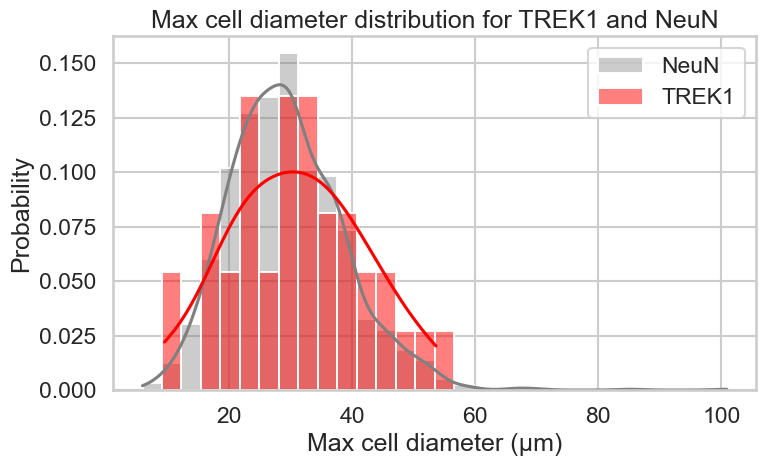

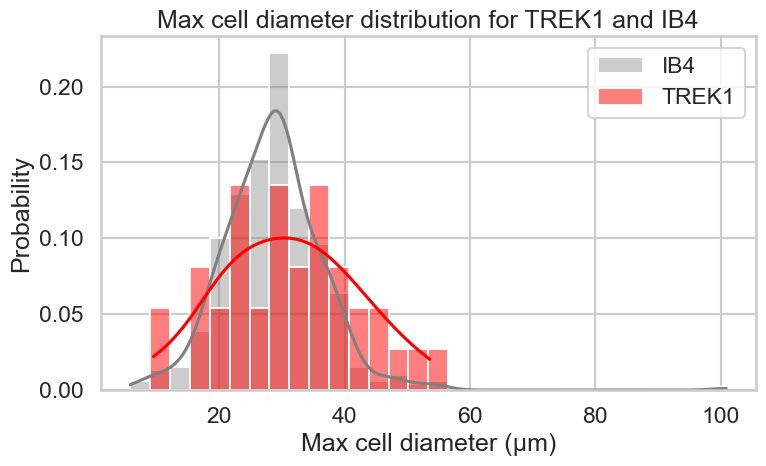

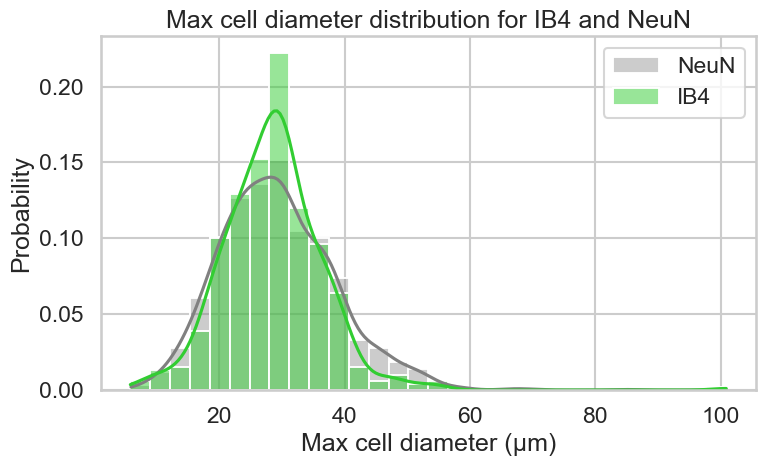

In [28]:
plot_histogram(df, 'TREK1', 'NeuN', metric='max_diameter', bins=30)
plot_histogram(df, 'TREK1', 'IB4', metric='max_diameter', bins=30)
plot_histogram(df, 'IB4', 'NeuN', metric='max_diameter', bins=30)

In [24]:
"""
Function to plot a swarmplot of cell sizes (area or max_diameter), allowing to compare the distribution between groups.
"""

def plot_size(
    df,
    marker, # name of the marker to plot
    metric='area', # 'area' or 'max_diameter
    group_by=None, # column used to make group to compare (e.g. level, animal)
    individual='cell', # column on which individual datapoints are based (keep individual cells or average by sample or slide for example)
    hue=None, # column used for coloring (e.g. sex)
    point_size=None # size of dots for the graph. If None, it will automatically adapt to the number of datapoints to avoid points overlapping
    ):

    # filter to marker-positive cells
    marker_col = marker + '_class'
    df = df[df[marker_col]]

    # if no grouping is specified, create dummy group for all data
    if group_by is None:
        df = df.copy()
        df['all'] = ''
        group_by = 'all'

    # prepare a summary df for individual datapoints (keep cells or average area/diameter)
    if individual == 'cell':
        # keep all rows
        summary = df[[individual, group_by, metric]].copy()
        summary.rename(columns={metric: 'mean'}, inplace=True)
        if hue:
            summary[hue] = df[hue].values
    else:
        # average metric per individual
        summary = (
            df.groupby(individual)[metric]
            .mean()
            .reset_index(name='mean')
        )
        # add grouping and hue columns (take first value per individual)
        summary[group_by] = df.groupby(individual)[group_by].first().values
        if hue:
            summary[hue] = df.groupby(individual)[hue].first().values

    # Calculate aspect ratio based on the number of groups
    n_groups = summary[group_by].nunique()
    width_per_group = 2.5
    fig_width = max(2.5, min(width_per_group * n_groups, 20))
    fig_height = 6

    # adapt dot size to the number of datapoints to avoid dots overlapping on both sides of the plot
    n_points = len(summary)
    if point_size is None:
        point_size = max(1, 8 - 2 * np.log10(n_points))  # logarithmic decay

    # set seaborn style
    sns.set(style="whitegrid", context="talk")
    plt.figure(figsize=(fig_width, fig_height))

    # swarmplot
    plt.figure(figsize=(fig_width, fig_height))
    ax = sns.swarmplot(
        data=summary,
        x=group_by,
        y='mean',
        hue=hue,
        dodge=True if hue else False,
        size=point_size,
        alpha=0.8
        )

    # overlay mean and SD per group
    stats = summary.groupby(group_by)['mean'].agg(['mean', 'std']).reset_index()
    for i, row in stats.iterrows():
        ax.hlines(y=row['mean'], xmin=i-0.3, xmax=i+0.3, color='black', linewidth=1.5, zorder=3)
        ax.vlines(x=i, ymin=row['mean']-row['std'], ymax=row['mean']+row['std'], color='black', linewidth=0.5, zorder=3)

    # Labels and title
    ax.set_xlabel(group_by)
    if metric == 'area':
        ax.set_ylabel('Cell area (µm²)')
        title = f"Distribution of cell area (grouped by {group_by}, datapoint = {individual})"
        if marker:
            title = f"Distribution of {marker}+ cell area\n(grouped by {group_by}, datapoint = {individual})"
        plt.title(title)
    elif metric == 'max_diameter':
        ax.set_ylabel('Max cell diameter (µm)')
        title = f"Distribution of cell area (grouped by {group_by}, datapoint = {individual})"
        if marker:
            title = f"Distribution of {marker}+ cell max diameter\n(grouped by {group_by}, datapoint = {individual})"
        plt.title(title)
    plt.tight_layout(rect=[0, 0, 0.85, 0.96])
    if hue:
        plt.legend(title=hue, bbox_to_anchor=(1.02, 1), loc='upper left')
    else:
        if ax.legend_:
            ax.legend_.remove()        
    plt.tight_layout()
    plt.savefig(analysis_path + f"swarmplot_{metric}_BY_{group_by}_INDIV_{individual}_HUE_{hue}.png", dpi=300, bbox_inches='tight')
    plt.show()

<Figure size 750x600 with 0 Axes>

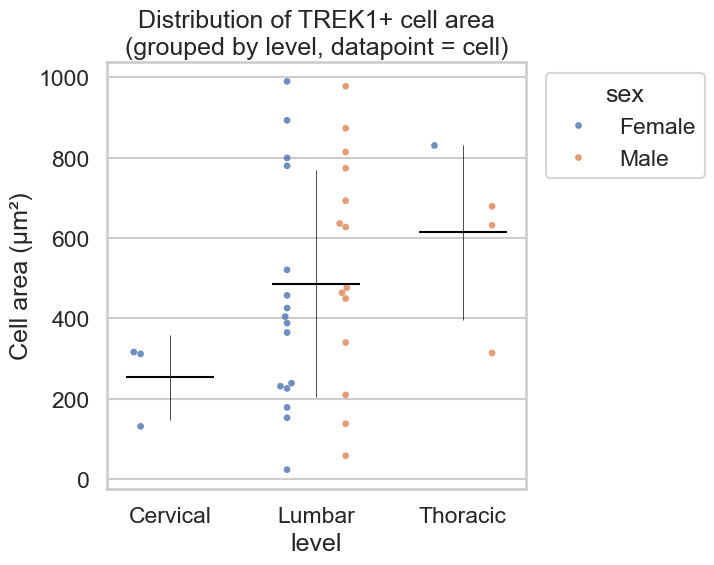

<Figure size 750x600 with 0 Axes>

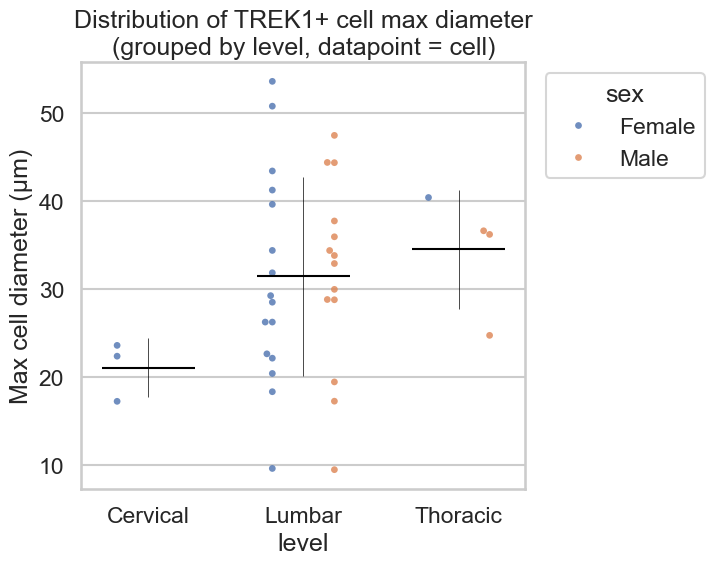

In [25]:
plot_size(df, marker='TREK1', metric='area', group_by='level', individual='cell', hue='sex')
plot_size(df, marker='TREK1', metric='max_diameter', group_by='level', individual='cell', hue='sex')

<Figure size 750x600 with 0 Axes>

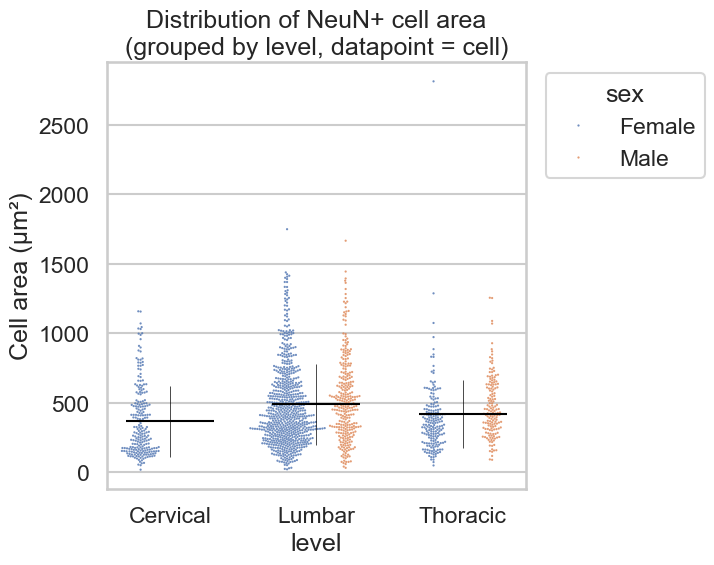

<Figure size 750x600 with 0 Axes>

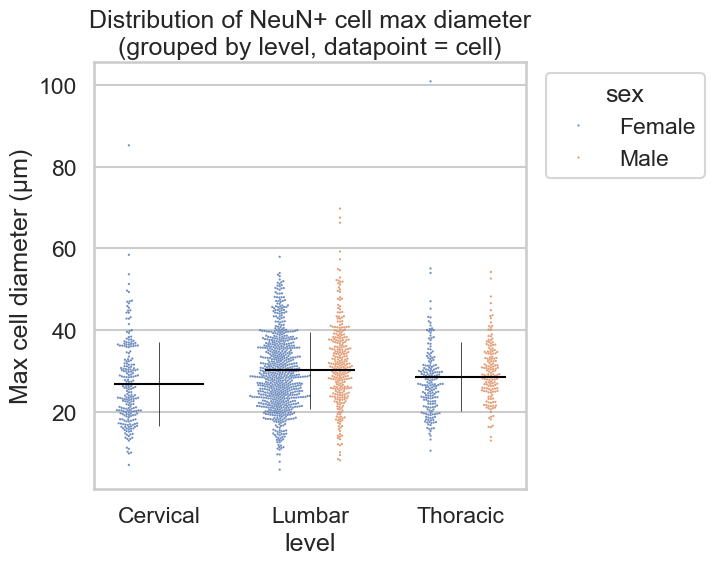

In [26]:
plot_size(df, marker='NeuN', metric='area', group_by='level', individual='cell', hue='sex')
plot_size(df, marker='NeuN', metric='max_diameter', group_by='level', individual='cell', hue='sex')

<Figure size 750x600 with 0 Axes>

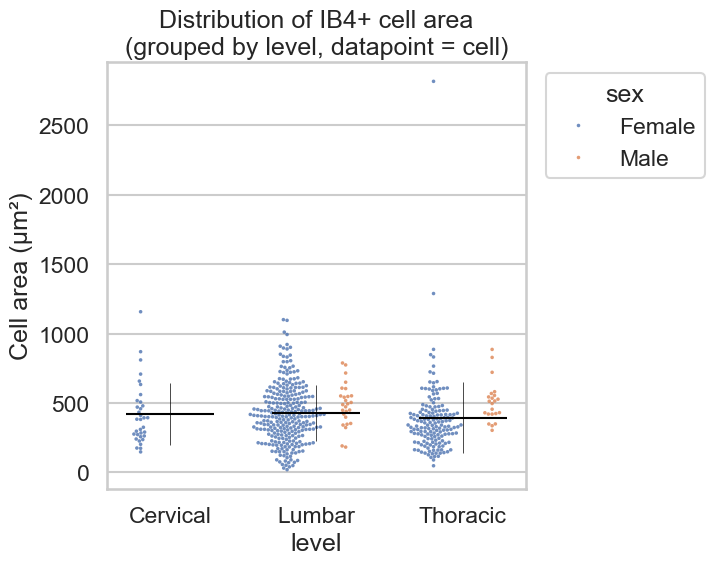

<Figure size 750x600 with 0 Axes>

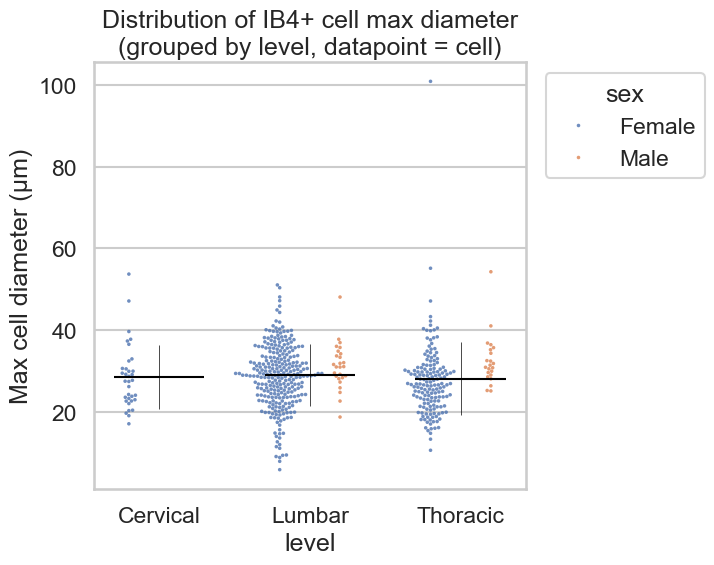

In [27]:
plot_size(df, marker='IB4', metric='area', group_by='level', individual='cell', hue='sex')
plot_size(df, marker='IB4', metric='max_diameter', group_by='level', individual='cell', hue='sex')